# Análisis Exploratorio

## Importación de librerías

In [387]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pyproj import Transformer

## Lectura del dataset

In [238]:
df = pd.read_csv("../../data/raw/historico_completo.csv")

df.head()

,fecha,dia,tempMedia,tempMax,horMinTempMax,tempMin,horMinTempMin,humedadMedia,humedadMax,horMinHumMax,...,velVientoMax,horMinVelMax,dirVientoVelMax,radiacion,precipitacion,bateria,fechaUtlMod,et0,provincia_id,codigoEstacion
0,2005-01-01,1,9.07,18.58,14:30,0.658,07:20,67.31,87.2,07:40,...,5.008,11:51,338.1,11.110,0.0,12.93,2005-01-02T07:34:55.000+0100,1.495588,11,1
1,2005-01-02,2,9.02,12.17,14:50,5.810,21:30,84.70,91.8,23:30,...,4.106,15:44,333.5,4.173,0.0,12.92,2005-01-03T07:37:28.000+0100,0.776324,11,1
2,2005-01-03,3,8.18,15.91,14:20,3.196,06:10,80.60,92.9,11:50,...,5.174,14:43,318.2,9.090,0.2,12.94,2005-01-04T07:34:53.000+0100,1.327342,11,1
3,2005-01-04,4,10.55,18.26,12:40,3.608,07:30,68.63,87.2,06:50,...,7.680,12:48,116.6,10.400,0.0,12.93,2005-01-05T07:34:53.000+0100,1.796508,11,1
4,2005-01-05,5,9.82,17.78,14:50,2.802,07:30,67.62,87.5,06:10,...,4.508,11:12,145.7,11.090,0.0,12.93,2005-01-06T07:35:04.000+0100,1.371563,11,1


Cargamos el dataset de "Estaciones". Este dataset contiene información sobre cada una de las estaciones meteorológicas incluidas en nuestro dataset de datos agroclimáticos.

In [ ]:
df_est = pd.read_csv("../../data/raw/estaciones.csv")
df_est.head()

,codigoEstacion,nombre,bajoplastico,activa,visible,longitud,latitud,altitud,xutm,yutm,huso,provincia_id,provincia_nombre
0,10,Adra,False,True,True,025932000W,364448000N,2,500683.0,4066780.0,30,4,Almería
1,2,Almería,False,True,True,022408000W,365007000N,5,553282.0,4076780.0,30,4,Almería
2,8,Cuevas de Almanzora,False,True,True,014801000W,371524000N,28,606367.0,4124030.0,30,4,Almería
3,5,Fiñana,False,True,True,025019000W,370924000N,958,514311.0,4112270.0,30,4,Almería
4,7,Huércal-Overa,False,True,True,015303000W,372444000N,303,598735.0,4141210.0,30,4,Almería


## Información general

### Dataset Estaciones

In [386]:
df_est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   codigoEstacion    101 non-null    int64  
 1   nombre            101 non-null    object 
 2   bajoplastico      101 non-null    bool   
 3   activa            101 non-null    bool   
 4   visible           101 non-null    bool   
 5   longitud          101 non-null    object 
 6   latitud           101 non-null    object 
 7   altitud           101 non-null    int64  
 8   xutm              101 non-null    float64
 9   yutm              101 non-null    float64
 10  huso              101 non-null    int64  
 11  provincia_id      101 non-null    int64  
 12  provincia_nombre  101 non-null    object 
dtypes: bool(3), float64(2), int64(4), object(4)
memory usage: 8.3+ KB


Analizamos los atributos del dataset "Estaciones":
* codigoEstacion: lo utilizaremos para unificar ambos dataset.
* nombre: nombre de la estación, no aporta valor.
* bajoplastico: variable booleana que indica si una estación está bajo plástico o no, es decir, si está al aire libre (0) o no (1).
* activa: variable booleana que indica si una estación está activa o no. Teniendo en cuenta que solo vamos a analizar las que estaban identificadas como activas en el dataset de datos climáticos, esta columna no aporta valor.
* visible: es una variable que recoge si los datos climáticos de esa estación está disponible o no para consultarla. Como ya tenemos los datos, esta columna tampoco nos resulta útil.
* longitud: variable de tipo object que incluye información sobre la longitud de la ubicación de la estación en formato GMS. Tendríamos que transformar este dato a numético para poder utilizarlo. 
* latitud: variable de tipo object que incluye información sobre la latitud de la ubicación de la estación en formato GMS. Tendríamos que transformar este dato a numético para poder utilizarlo.
* altitud: altura respecto al nivel del mar de la estación
* xutm: coordenadas en formato UTM
* yutm: coordenadas en formato UTM
* Huso: huso de las coordenadas UTM en el que se encuentra la estación
* provincia_id: identificador de la provincia en que se encuentra la estación. Lo utilizaremos junto a codigoEstacion para unificar los datasets
* provincia_nombre: nombre de la provincia en que se encuentra la estación.


Como muchas librerías de python utilizan las coordenadas en formato latitud y longitud, vamos a transformar esta variable. Vemos que longitud y latitud está en formato String, incluyendo el sentido en letra. Como disponemos de las coordenadas en formato UTM, vamos a utilizar una librería de Python para transformarlos en las coordenadas deseadas. Antes de continuar, comprobamos el huso en el que se encuentra nuestras coordenadas UTM.

In [388]:
df_est['huso'].value_counts()

huso
30    101
Name: count, dtype: int64

Todas la estaciones se encuentran en el mismo huso: 30.

In [ ]:
transformer = Transformer.from_crs("epsg:32630", "epsg:4326", always_xy=True)

In [ ]:
df_est.describe()

,codigoEstacion,altitud,xutm,yutm,huso,provincia_id
count,101.000000,101.000000,101.000000,1.010000e+02,101.0,101.000000
mean,22.069307,282.158416,348010.723960,4.134343e+06,30.0,22.356436
std,33.931772,306.081124,131250.343973,5.229526e+04,0.0,11.164752
min,1.000000,1.000000,123877.000000,4.019310e+06,30.0,4.000000
25%,5.000000,38.000000,230594.000000,4.099810e+06,30.0,14.000000
50%,8.000000,171.000000,346918.000000,4.128400e+06,30.0,21.000000
75%,15.000000,494.000000,451202.000000,4.172400e+06,30.0,29.000000
max,107.000000,1201.000000,608847.000000,4.263000e+06,30.0,41.000000


In [ ]:
df_est.isnull().sum()

codigoEstacion      0
nombre              0
bajoplastico        0
activa              0
visible             0
longitud            0
latitud             0
altitud             0
xutm                0
yutm                0
huso                0
provincia_id        0
provincia_nombre    0
dtype: int64

In [ ]:
df_est.duplicated().sum()

np.int64(0)

In [ ]:
print(df_est['codigoEstacion'].value_counts())

codigoEstacion
7      8
8      7
2      7
6      7
5      7
11     7
101    7
10     6
1      6
12     5
4      5
102    4
9      4
3      4
103    2
17     2
15     2
16     2
104    1
107    1
14     1
19     1
21     1
20     1
18     1
13     1
22     1
Name: count, dtype: int64


Podemos observar que varias estaciones tienen el mismo código de identificación.

In [ ]:
df_est[['codigoEstacion', 'provincia_id']].value_counts().sort_values(ascending=False)

codigoEstacion  provincia_id
1               4               1
                11              1
                14              1
                18              1
                23              1
                               ..
102             23              1
103             21              1
                23              1
104             23              1
107             21              1
Name: count, Length: 101, dtype: int64

Vemos que tenemos que utilizar 'codigoEstacion' y 'provincia_id' como clave primaria.

In [ ]:
df_est.columns

Index(['codigoEstacion', 'nombre', 'bajoplastico', 'activa', 'visible',
       'longitud', 'latitud', 'altitud', 'xutm', 'yutm', 'huso',
       'provincia_id', 'provincia_nombre'],
      dtype='object')

In [ ]:
df_est = df_est[['codigoEstacion', 'nombre', 'bajoplastico','longitud', 'latitud','altitud', 'provincia_id','provincia_nombre']]

In [ ]:
df_est

,codigoEstacion,nombre,bajoplastico,altitud,xutm,yutm,huso,provincia_id,provincia_nombre
0,10,Adra,False,2,500683.0,4066780.0,30,4,Almería
1,2,Almería,False,5,553282.0,4076780.0,30,4,Almería
2,8,Cuevas de Almanzora,False,28,606367.0,4124030.0,30,4,Almería
3,5,Fiñana,False,958,514311.0,4112270.0,30,4,Almería
4,7,Huércal-Overa,False,303,598735.0,4141210.0,30,4,Almería
...,...,...,...,...,...,...,...,...,...
96,16,Los Molares,False,77,262696.0,4117760.0,30,41,Sevilla
97,11,Osuna,False,198,310675.0,4125300.0,30,41,Sevilla
98,18,Puebla Cazalla,False,193,291408.0,4121660.0,30,41,Sevilla
99,13,Sanlúcar La Mayor,False,63,211943.0,4146640.0,30,41,Sevilla


### Dataset histórico meteorológico

In [239]:
df.shape

(690709, 24)

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690709 entries, 0 to 690708
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fecha            690709 non-null  object 
 1   dia              690709 non-null  int64  
 2   tempMedia        689485 non-null  float64
 3   tempMax          689588 non-null  float64
 4   horMinTempMax    690709 non-null  object 
 5   tempMin          689146 non-null  float64
 6   horMinTempMin    690709 non-null  object 
 7   humedadMedia     689194 non-null  float64
 8   humedadMax       688772 non-null  float64
 9   horMinHumMax     690709 non-null  object 
 10  humedadMin       688507 non-null  float64
 11  horMinHumMin     690709 non-null  object 
 12  velViento        681821 non-null  float64
 13  dirViento        681604 non-null  float64
 14  velVientoMax     681822 non-null  float64
 15  horMinVelMax     690709 non-null  object 
 16  dirVientoVelMax  682349 non-null  floa

In [241]:
df.select_dtypes('object').columns

Index(['fecha', 'horMinTempMax', 'horMinTempMin', 'horMinHumMax',
       'horMinHumMin', 'horMinVelMax', 'fechaUtlMod'],
      dtype='object')

Los atributos del dataset son:
* 'fecha': fecha en la que se tomó el registro
* 'dia': día del año
* 'tempMedia': temperatura media del día
* 'tempMax': temperatura máxima
* 'horMinTempMax': hora en la que se registró máxima temperatura
* 'tempMin': temperatura mínima
* 'horMinTempMin': hora a la que se registró la mínima temperatuna
* 'humedadMedia': humedad media
* 'humedadMax': humedad máxima del día
* 'horMinHumMax': hora y minutos en los que se registró la humedad máxima
* 'humedadMin': humedad mínima del día
* 'horMinHumMin': hora y minutos en el que se registró la humedad mínima 
* 'velViento': velocidad media del viento
* 'dirViento': dirección del viento
* 'velVientoMax': velocidad máxima del viento
* 'horMinVelMax': hora en el que se registró la velocidad máxima del viento 
* 'dirVientoVelMax': direccción viento de la velocidad máxima
* 'radiacion': radiación
* 'precipitacion': precipitación total en mm del día
* 'bateria': valor de la batería de la estación
* 'fechaUtlMod': fecha en la que se produjo la última modificación del registro
* 'et0': valor de la evotranspiración (variable objetivo)
* 'provincia_id': identificador de la provincia en la que se ubica la estación agroclimática
* 'codigoEstacion': identificador de la estación agroclimática

In [242]:
df.columns

Index(['fecha', 'dia', 'tempMedia', 'tempMax', 'horMinTempMax', 'tempMin',
       'horMinTempMin', 'humedadMedia', 'humedadMax', 'horMinHumMax',
       'humedadMin', 'horMinHumMin', 'velViento', 'dirViento', 'velVientoMax',
       'horMinVelMax', 'dirVientoVelMax', 'radiacion', 'precipitacion',
       'bateria', 'fechaUtlMod', 'et0', 'provincia_id', 'codigoEstacion'],
      dtype='object')

In [243]:
df = df[['fecha', 'dia', 'tempMedia', 'tempMax', 'horMinTempMax', 'tempMin',
       'horMinTempMin', 'humedadMedia', 'humedadMax', 'horMinHumMax',
       'humedadMin', 'horMinHumMin', 'velViento', 'dirViento', 'velVientoMax',
       'horMinVelMax', 'dirVientoVelMax', 'radiacion', 'precipitacion',
       'et0', 'provincia_id', 'codigoEstacion']]

Vemos que tendremos que transformar las columnas de fecha y hora en tipo Datetime. Además, detectamos a priori atributos que vamos a eliminar: batería de la estación y fecha de la última modificación.

Otro aspecto a tener en cuenta son las variables codigoEstacion y provincia_id. Estas variables son de tipo int. En realidad, estos identificadores deben ser tratados como variables categóricas. Si las dejaramos como número, el algoritmo de Machine Learning podría aprender patrones o atribuir una jerarquía a las distintas estaciones.

In [316]:
df['fecha']= pd.to_datetime(df['fecha'])

Vamos a estudiar la complitud de la serie temporal, es decir, que no existan huecos temporales en los registros de las estaciones.

In [384]:
def verificacion_serie_temporal(station_data):
       
    fecha_inicio = station_data.index.min()
    fecha_fin = station_data.index.max()
    
    rango_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
    
    dias_esperados = len(rango_completo)
    dias_reales = len(station_data)
    
    porcentaje_faltante = (1 - (dias_reales / dias_esperados)) * 100
    
    return pd.Series({
        'fecha_inicio': fecha_inicio,
        'fecha_fin': fecha_fin,
        'dias_esperados': dias_esperados,
        'dias_reales': dias_reales,
        'porcentaje_faltante': porcentaje_faltante
    })

df_index = df.set_index('fecha')
df_verificado = df_index.groupby(['codigoEstacion','provincia_id']).apply(verificacion_serie_temporal)

# Muestra las estaciones con más días faltantes primero
df_verificado.sort_values('porcentaje_faltante', ascending=False).round(2)

/tmp/ipykernel_168917/3974423395.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_verificado = df_index.groupby(['codigoEstacion','provincia_id']).apply(verificacion_serie_temporal)


,,fecha_inicio,fecha_fin,dias_esperados,dias_reales,porcentaje_faltante
codigoEstacion,provincia_id,,,,,
102,21,2008-11-20,2025-08-01,6099,4355,28.59
103,21,2011-12-01,2025-08-01,4993,3835,23.19
8,4,2005-01-01,2025-08-01,7518,6811,9.40
5,11,2005-01-01,2025-08-01,7518,7027,6.53
101,23,2006-04-06,2025-08-01,7058,6755,4.29
...,...,...,...,...,...,...
1,18,2005-01-01,2025-08-01,7518,7513,0.07
15,41,2005-01-01,2025-08-01,7518,7513,0.07
8,21,2005-01-01,2025-08-01,7518,7514,0.05


Vemos que las estaciones 102 y 103 presentan muchos datos faltantes (28,59% y 23,19% respectivamente). Nos dan un indicio que estas estaciones presentan una mala calidad de registros. En el notebook de verificación de calidad, estableceremos umbrales de calidad para eliminar los datos de las estaciones que no presenten una calidad aceptable.

In [244]:
df.describe()

,dia,tempMedia,tempMax,tempMin,humedadMedia,humedadMax,humedadMin,velViento,dirViento,velVientoMax,dirVientoVelMax,radiacion,precipitacion,et0,provincia_id,codigoEstacion
count,690709.000000,689485.000000,689588.000000,689146.000000,689194.000000,688772.000000,688507.000000,681821.000000,681604.000000,681822.000000,682349.000000,689706.000000,682214.000000,679335.000000,690709.000000,690709.000000
mean,180.901962,17.193925,24.005895,10.947206,63.673787,85.972722,37.937697,1.546672,190.716741,6.035419,194.495092,18.041855,1.273554,3.648371,22.393258,20.006735
std,105.144790,6.909024,7.972695,6.231762,17.815849,14.063385,18.105349,0.972314,96.962238,8.779430,95.323961,8.196402,5.748707,2.167635,11.415548,31.936172
min,1.000000,-17.910000,-7.140000,-39.870000,0.808000,10.000000,-1.016000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042203,4.000000,1.000000
25%,90.000000,11.710000,17.590000,6.357000,50.520000,79.100000,23.470000,0.906000,101.400000,4.449000,116.300000,11.070000,0.000000,1.675095,14.000000,5.000000
50%,179.000000,16.790000,23.330000,11.110000,65.320000,90.000000,36.040000,1.324000,213.400000,5.684000,216.700000,17.910000,0.000000,3.324815,21.000000,8.000000
75%,272.000000,22.870000,30.350000,15.860000,77.500000,97.300000,50.130000,1.906000,268.800000,7.170000,267.500000,25.660000,0.100000,5.444859,29.000000,13.000000
max,366.000000,37.810000,134.400000,29.670000,100.000000,153.000000,100.000000,13.580000,360.000000,6999.000000,6999.000000,61.530000,2126.000000,22.901576,41.000000,104.000000


In [245]:
print(f"Hay {df.duplicated().sum()} instancias duplicadas. Supone un {round(df.duplicated().sum()/df.shape[0]*100,2)}%")

Hay 107 instancias duplicadas. Supone un 0.02%


Eliminaremos los registros duplicados.

In [246]:
df=df.drop_duplicates()

In [247]:
print(f"Hay {df.duplicated().sum()} instancias duplicadas. Supone un {round(df.duplicated().sum()/df.shape[0]*100,2)}%")

Hay 0 instancias duplicadas. Supone un 0.0%


 Pasamos a revisar los valores nulos del dataset:

In [355]:
var_nulas = df.isnull().sum()
var_nulas

fecha                  0
dia                    0
tempMedia           1219
tempMax             1116
horMinTempMax          0
tempMin             1558
horMinTempMin          0
humedadMedia        1509
humedadMax          1931
horMinHumMax           0
humedadMin          2196
horMinHumMin           0
velViento           8879
dirViento           9096
velVientoMax        8878
horMinVelMax           0
dirVientoVelMax     8351
radiacion            998
precipitacion       8486
et0                11364
provincia_id           0
codigoEstacion         0
dtype: int64

In [356]:
round(var_nulas/df.shape[0]*100,2).sort_values(ascending=False)

et0                1.65
dirViento          1.32
velViento          1.29
velVientoMax       1.29
precipitacion      1.23
dirVientoVelMax    1.21
humedadMin         0.32
humedadMax         0.28
tempMin            0.23
humedadMedia       0.22
tempMedia          0.18
tempMax            0.16
radiacion          0.14
fecha              0.00
horMinTempMax      0.00
dia                0.00
horMinTempMin      0.00
horMinHumMax       0.00
horMinHumMin       0.00
horMinVelMax       0.00
provincia_id       0.00
codigoEstacion     0.00
dtype: float64

En general, vemos que hay pocos valores nulos. Sin embargo, esto no es significativo. Tenemos registros de diferentes estaciones. Por tanto, tenemos que estudiar cómo afectan los valores nulos a cada estación y ver qué estrategias podríamos seguir para su tratamiento en la fase de preprocesamiento.

In [329]:
total_nulos_por_estacion = df.isnull().groupby([df['codigoEstacion'], df['provincia_id']]).sum().sum(axis=1)
total_celdas_por_estacion = df.groupby(['codigoEstacion', 'provincia_id']).size() * len(df.columns)
porcentaje_nulos_total = (total_nulos_por_estacion / total_celdas_por_estacion) * 100
resultado = porcentaje_nulos_total.round(2).sort_values(ascending=False)
resultado

codigoEstacion  provincia_id
103             21              27.39
102             21              27.12
12              18               1.10
17              23               0.71
102             18               0.44
                                ...  
10              18               0.02
102             14               0.02
10              29               0.01
15              41               0.01
18              41               0.00
Length: 100, dtype: float64

Detectamos que las estaciones 102 y 103 de la provincia 21 presentan un alto porcentaje de valores nulos. El resto de estaciones, tienen un número despreciable respecto al total de números de registros. Veamos como se distribuyen a lo largo de los atributos:

In [330]:
nulos_est = df.isnull().groupby([df['codigoEstacion'], df['provincia_id']]).sum()
nulos_est = nulos_est.loc[:, nulos_est.sum() > 0]
nulos_est

tempMedia  tempMax  tempMin  humedadMedia  \
codigoEstacion provincia_id                                              
1              4                    31       31       32            30   
               11                   29       26       33            30   
               14                    4        4        8            15   
               18                    5        2        9             4   
               23                    5        5        5             5   
...                                ...      ...      ...           ...   
102            21                   65       65       70            64   
               23                    4        4        5             3   
103            21                   78       78       78            79   
               23                    6        5        8             4   
104            23                    1        1        7             1   

                             humedadMax  humedadMin  velViento  dirViento  \
codigoEstacion provincia_id                                                 
1              4                     27          35          1          1   
               11                    53          40         25         25   
               14                    15          19          4          4   
               18                     3          11          2          2   
               23                     5           9          5          5   
...                                 ...         ...        ...        ...   
102            21                    65          69       4331       4330   
               23                     2           8          1          1   
103            21                    79          79       3812       3812   
               23                     4          10          4          4   
104            23                     1          10          0         35   

                             velVientoMax  dirVientoVelMax  radiacion  \
codigoEstacion provincia_id                                             
1              4                        1                1          8   
               11                      25               25         23   
               14                       4                4          4   
               18                       2                2          3   
               23                       5                5         26   
...                                   ...              ...        ...   
102            21                    4331             4025         64   
               23                       1                1         24   
103            21                    3812             3655         79   
               23                       4                4          5   
104            23                       0                0          7   

                             precipitacion   et0  
codigoEstacion provincia_id                       
1              4                         1    42  
               11                       28    73  
               14                       12    20  
               18                        2    12  
               23                        5    30  
...                                    ...   ...  
102            21                     4176  4331  
               23                        1    34  
103            21                     3655  3813  
               23                        4    12  
104            23                        0    17  

[100 rows x 13 columns]

En porcentaje respecto al total de nulos de la estación:

In [331]:
total_nulos_por_est = nulos_est.sum(axis=1)
distribucion_porcentual_est = (nulos_est.div(total_nulos_por_est, axis=0)) * 100
distribucion_porcentual_est

tempMedia    tempMax    tempMin  humedadMedia  \
codigoEstacion provincia_id                                                  
1              4             12.863071  12.863071  13.278008     12.448133   
               11             6.666667   5.977011   7.586207      6.896552   
               14             3.418803   3.418803   6.837607     12.820513   
               18             8.474576   3.389831  15.254237      6.779661   
               23             4.347826   4.347826   4.347826      4.347826   
...                                ...        ...        ...           ...   
102            21             0.250135   0.250135   0.269376      0.246286   
               23             4.494382   4.494382   5.617978      3.370787   
103            21             0.337531   0.337531   0.337531      0.341858   
               23             8.108108   6.756757  10.810811      5.405405   
104            23             1.250000   1.250000   8.750000      1.250000   

                             humedadMax  humedadMin  velViento  dirViento  \
codigoEstacion provincia_id                                                 
1              4              11.203320   14.522822   0.414938   0.414938   
               11             12.183908    9.195402   5.747126   5.747126   
               14             12.820513   16.239316   3.418803   3.418803   
               18              5.084746   18.644068   3.389831   3.389831   
               23              4.347826    7.826087   4.347826   4.347826   
...                                 ...         ...        ...        ...   
102            21              0.250135    0.265528  16.666667  16.662818   
               23              2.247191    8.988764   1.123596   1.123596   
103            21              0.341858    0.341858  16.495738  16.495738   
               23              5.405405   13.513514   5.405405   5.405405   
104            23              1.250000   12.500000   0.000000  43.750000   

                             velVientoMax  dirVientoVelMax  radiacion  \
codigoEstacion provincia_id                                             
1              4                 0.414938         0.414938   3.319502   
               11                5.747126         5.747126   5.287356   
               14                3.418803         3.418803   3.418803   
               18                3.389831         3.389831   5.084746   
               23                4.347826         4.347826  22.608696   
...                                   ...              ...        ...   
102            21               16.666667        15.489110   0.246286   
               23                1.123596         1.123596  26.966292   
103            21               16.495738        15.816349   0.341858   
               23                5.405405         5.405405   6.756757   
104            23                0.000000         0.000000   8.750000   

                             precipitacion        et0  
codigoEstacion provincia_id                            
1              4                  0.414938  17.427386  
               11                 6.436782  16.781609  
               14                10.256410  17.094017  
               18                 3.389831  20.338983  
               23                 4.347826  26.086957  
...                                    ...        ...  
102            21                16.070192  16.666667  
               23                 1.123596  38.202247  
103            21                15.816349  16.500065  
               23                 5.405405  16.216216  
104            23                 0.000000  21.250000  

[100 rows x 13 columns]

Analizamos como se distribuyen los nulos en cada estación. Podemos observar que, en general, falta registros porque ha podido haber algún fallo en un sensor. Uno de los atributos que presenta mayor número de valores nulos es ET0. Esto tiene sentido porque es una medida que se calcula a partir de los datos meteorológicos registrados y, si faltaba alguno de ellos, no podía hacerse el cálculo. 

Ahora vamos a analizar más en profundidad las dos estaciones que hemos detectado que las dos estaciones problemáticas son la 103 y 102 de la provincia 21. Vamos a ver cómo se distribuye a lo largo del tiempo el registro de valores nulos.

In [332]:
nulos_fecha_est10321 = df[(df['provincia_id']==21) & (df['codigoEstacion']==103)].isnull().groupby([df['fecha']]).sum().sum(axis=1)
nulos_fecha_est10321 = nulos_fecha_est10321.to_frame()
nulos_fecha_est10321 = nulos_fecha_est10321.reset_index()
nulos_fecha_est10321.columns = ['fecha', 'total_nulos']
nulos_fecha_est10321.head()

,fecha,total_nulos
0,2011-12-01,6
1,2011-12-02,6
2,2011-12-03,6
3,2011-12-04,6
4,2011-12-05,6


In [333]:
nulos_fecha_est10221 = df[(df['provincia_id']==21) & (df['codigoEstacion']==102)].isnull().groupby([df['fecha']]).sum().sum(axis=1)
nulos_fecha_est10221 = nulos_fecha_est10221.to_frame()
nulos_fecha_est10221 = nulos_fecha_est10221.reset_index()
nulos_fecha_est10221.columns = ['fecha', 'total_nulos']
nulos_fecha_est10221.head()

,fecha,total_nulos
0,2008-11-20,7
1,2008-11-21,6
2,2008-11-22,6
3,2008-11-23,6
4,2008-11-24,6


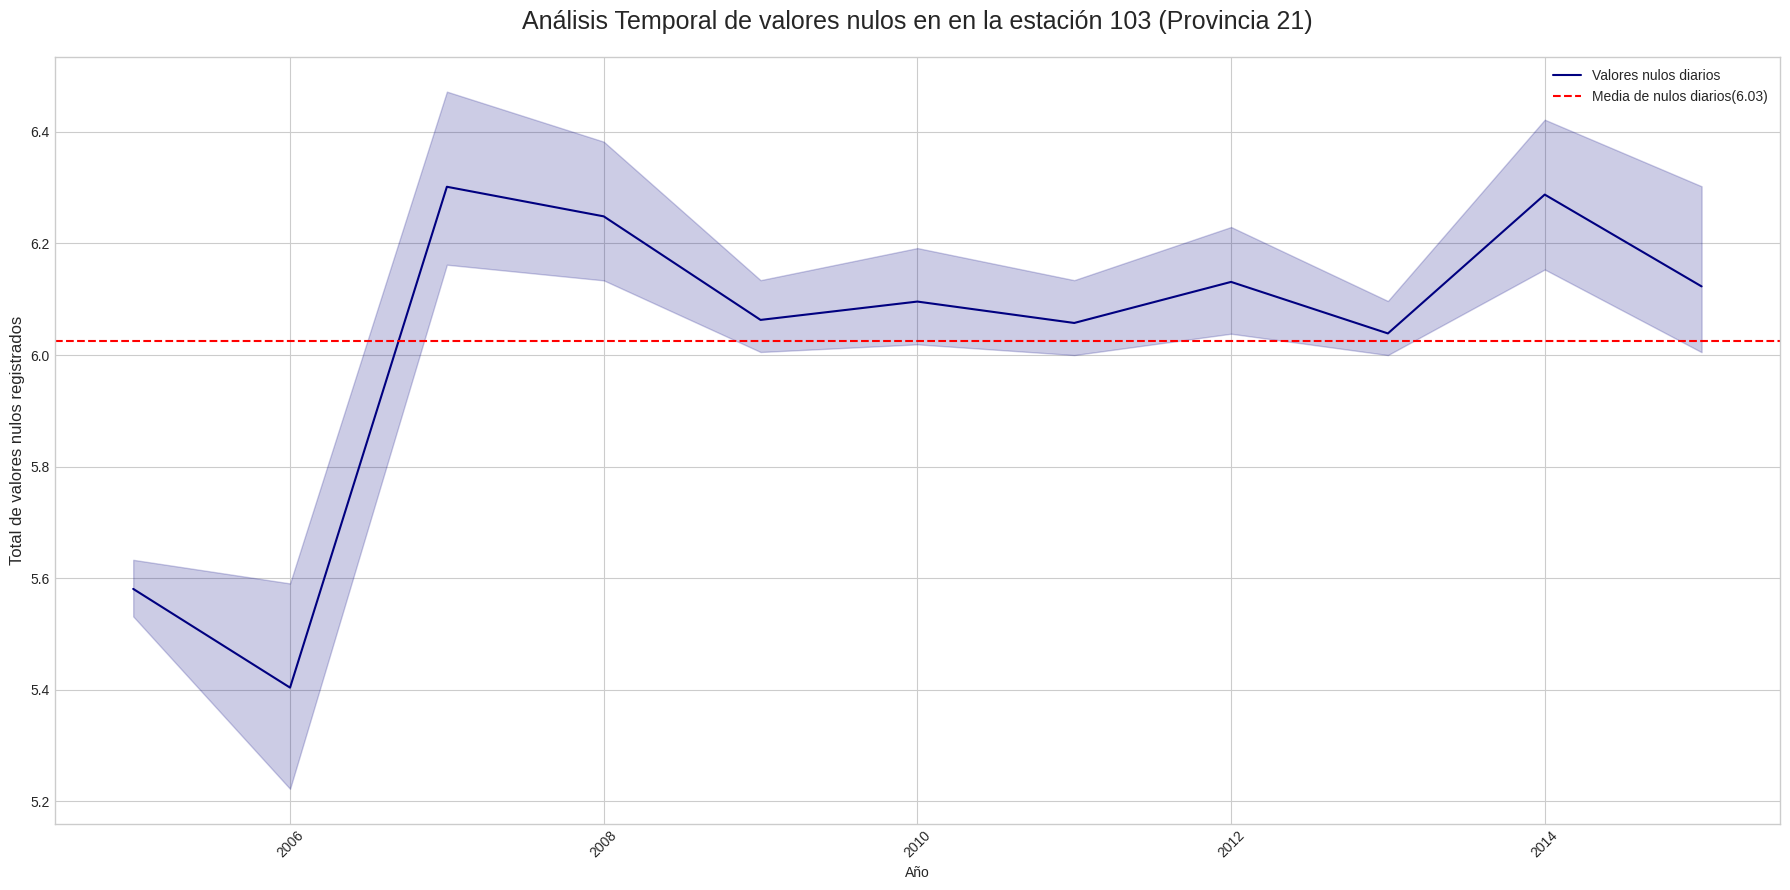

In [373]:
plt.figure(figsize=(18, 9))

sns.lineplot(x=df['fecha'].dt.year, y=nulos_fecha_est10321['total_nulos'], label='Valores nulos diarios', color='navy')

plt.xticks(rotation=45)

media_nulos = nulos_fecha_est10321['total_nulos'].mean()
plt.axhline(y=media_nulos, color='red', linestyle='--', label=f'Media de nulos diarios({media_nulos:.2f})')

plt.title('Análisis Temporal de valores nulos en en la estación 103 (Provincia 21)', fontsize=18, pad=20)
plt.xlabel('Año', fontsize=10)
plt.ylabel('Total de valores nulos registrados', fontsize=12)

plt.legend()
plt.tight_layout()
plt.show()

Podemos observar que, de forma costante, la estación falla en la recogida de información.

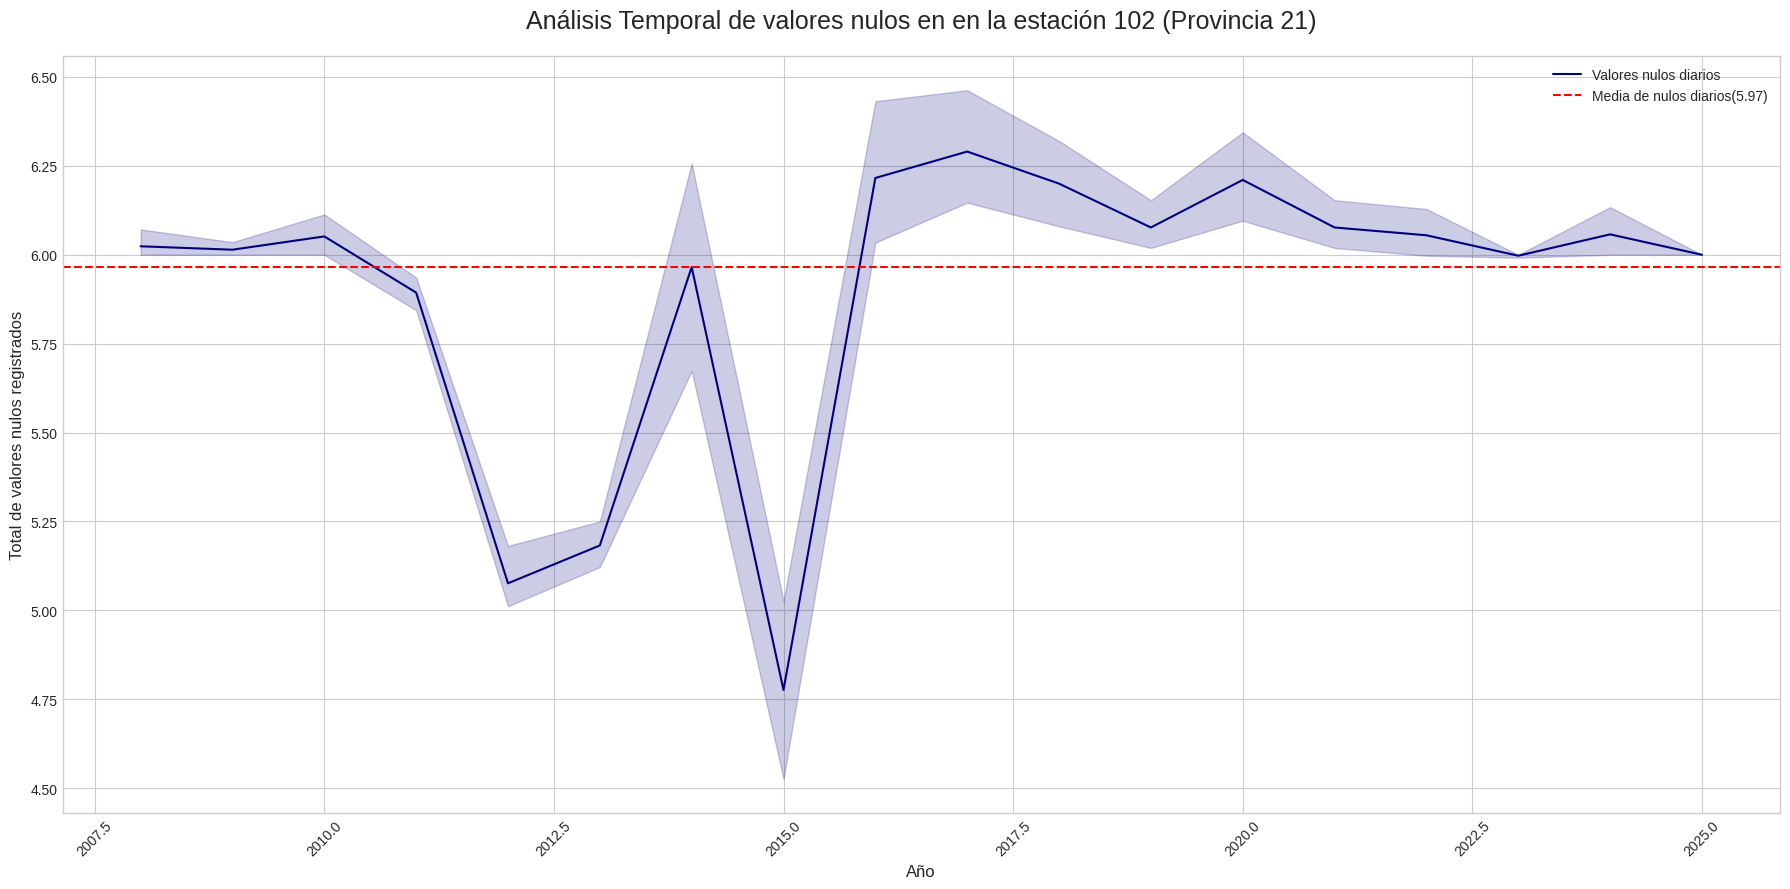

In [369]:
fig = plt.figure(figsize=(18, 9))

ax = sns.lineplot(x=nulos_fecha_est10221['fecha'].dt.year, y = nulos_fecha_est10221['total_nulos'], label='Valores nulos diarios', color='navy')

plt.xticks(rotation=45)
media_nulos = nulos_fecha_est10221['total_nulos'].mean()
plt.axhline(y=media_nulos, color='red', linestyle='--', label=f'Media de nulos diarios({media_nulos:.2f})')
plt.title('Análisis Temporal de valores nulos en en la estación 102 (Provincia 21)', fontsize=18, pad=20)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Total de valores nulos registrados', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

En este caso, podemos ver como el año 2015 hay un descenco significativo de valores faltantes (puede coincidir con algún tipo de mantenimiento de la estación), pero vuelve a estabilizarse a partir de 2016. Entre el análisis de completitud y de valores nulos, tenemos argumentos suficientes para valorar eliminar estas dos estaciones del análisis.

### Unificación metadatos de las estaciones y sus datos meteorológicos

In [ ]:
data = pd.merge(df, df_est, on=["codigoEstacion", "provincia_id"])

In [359]:
data.head()

,fecha,dia,tempMedia,tempMax,horMinTempMax,tempMin,horMinTempMin,humedadMedia,humedadMax,horMinHumMax,...,bajoplastico,activa,visible,longitud,latitud,altitud,xutm,yutm,huso,provincia_nombre
0,2005-01-01,1,9.07,18.58,14:30,0.658,07:20,67.31,87.2,07:40,...,False,True,True,060102000W,364525000N,39,230650.0,4072170.0,30,Cádiz
1,2005-01-02,2,9.02,12.17,14:50,5.810,21:30,84.70,91.8,23:30,...,False,True,True,060102000W,364525000N,39,230650.0,4072170.0,30,Cádiz
2,2005-01-03,3,8.18,15.91,14:20,3.196,06:10,80.60,92.9,11:50,...,False,True,True,060102000W,364525000N,39,230650.0,4072170.0,30,Cádiz
3,2005-01-04,4,10.55,18.26,12:40,3.608,07:30,68.63,87.2,06:50,...,False,True,True,060102000W,364525000N,39,230650.0,4072170.0,30,Cádiz
4,2005-01-05,5,9.82,17.78,14:50,2.802,07:30,67.62,87.5,06:10,...,False,True,True,060102000W,364525000N,39,230650.0,4072170.0,30,Cádiz


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500117 entries, 0 to 500116
Data columns (total 29 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   fecha             500117 non-null  object 
 1   dia               500117 non-null  int64  
 2   tempMedia         499218 non-null  float64
 3   tempMax           499290 non-null  float64
 4   horMinTempMax     500117 non-null  object 
 5   tempMin           499002 non-null  float64
 6   horMinTempMin     500117 non-null  object 
 7   humedadMedia      499032 non-null  float64
 8   humedadMax        498655 non-null  float64
 9   horMinHumMax      500117 non-null  object 
 10  humedadMin        498555 non-null  float64
 11  horMinHumMin      500117 non-null  object 
 12  velViento         491452 non-null  float64
 13  dirViento         491297 non-null  float64
 14  velVientoMax      491449 non-null  float64
 15  horMinVelMax      500117 non-null  object 
 16  dirVientoVelMax   49

## Análisis Temporal

In [364]:
df['fecha'].dt.year

0         2005
1         2005
2         2005
3         2005
4         2005
          ... 
690704    2025
690705    2025
690706    2025
690707    2025
690708    2025
Name: fecha, Length: 690602, dtype: int32

pandas._libs.tslibs.timestamps.Timestamp